# Problem 1

Get familiar with real genetic gate designs by working through the following code.

In [70]:
from urllib.request import urlopen
import json
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
%matplotlib inline

figsize=(6, 4.5)

## Obtaining model and experimental data

[Cello](https://github.com/CIDARLAB/Cello-v2) is a genetic circuit compiler.
It compiles circuits written in a hardare description language (a sublanguage of `Verilog`) into
  `NOR` and `NOT` gates, to then finally generate DNA with the genetic circuit in it.
Check out the paper by [Nielsen et al.](https://www.science.org/doi/full/10.1126/science.aac7341?casa_token=s0MZasgUtiIAAAAA:hYS8PI5tJ8VqU6daoE-T3BgoOjrA_iXwvzjwFrqeUDiSA3zP5DMc6STWS7mJUZBA8x33QPrCxrvSWw) for a description of the compiler.

We will use modeling and experimental data from the Cello v2 compiler in the form of a [UCF file](https://github.com/CIDARLAB/Cello-UCF/blob/cfb4de1cf125a6fb5af1971730844ea5d0e91623/files/v2/ucf/Eco/Eco1C1G1T1.UCF.json).
Let's load it into a variable so that we can work with it.

In [71]:
# fetch it form this url
url = "https://github.com/CIDARLAB/Cello-UCF/raw/cfb4de1cf125a6fb5af1971730844ea5d0e91623/files/v2/ucf/Eco/Eco1C1G1T1.UCF.json"
  
# get & parse
response = urlopen(url)
ucf_data = json.loads(response.read())

# if stored locally use this:
#
# with open('Eco1C1G1T1.UCF.json','r') as f:
#     s = f.read()
# ucf_data = json.loads(s)

And check out what is inside. It is a list that starts with a `header` that includes general information from the used bacteria to experimental conditions under which data was obtained:

In [72]:
from pprint import pprint

pprint(ucf_data[0])

{'author': ['Bryan Der', 'Timothy Jones'],
 'collection': 'header',
 'date': 'Thu Dec 24 00:56:10 EST 2015',
 'description': 'TetR homologs: PhlF, SrpR, BM3R1, HlyIIR, BetI, AmtR, AmeR, '
                'QacR, IcaRA, LitR, PsrA, LmrA',
 'genome': 'NEB 10 ∆(ara-leu) 7697 araD139 fhuA ∆lacX74 galK16 galE15 e14- '
           'φ80dlacZ∆M15  recA1 relA1 endA1 nupG  rpsL (StrR) rph spoT1 '
           '∆(mrr-hsdRMS-mcrBC)',
 'growth': 'Inoculation: Individual colonies into M9 media, 16 hours overnight '
           'in plate shaker.  Dilution: Next day, cells dilute ~200-fold into '
           'M9 media with antibiotics, growth for 3 hours.  Induction: Cells '
           'diluted ~650-fold into M9 media with antibiotics.  Growth: shaking '
           'incubator for 5 hours.  Arrest protein production: PBS and 2mg/ml '
           'kanamycin.  Measurement: flow cytometry, data processing for RPU '
           'normalization.',
 'media': 'M9 minimal media composed of M9 media salts (6.78 g/L Na2H

To get an overview on all the elements stored in the UCF file, let's see the `collection` names for all entries. These describe the type of the item. Since the list is quite long, we compact it into a set to remove multiples.

In [73]:
pprint(set([d['collection'] for d in ucf_data]))

{'circuit_rules',
 'device_rules',
 'functions',
 'gates',
 'genetic_locations',
 'header',
 'logic_constraints',
 'measurement_std',
 'models',
 'motif_library',
 'parts',
 'structures'}


## A NOR gate from the library

The library contains `gates` as can be seen in the `collection` variables.
Le us study one such gate: the `S3_SrpR`.


In [74]:
gates_lib = [d for d in ucf_data if d['collection'] == 'gates']

gate_names = map(lambda x: x["name"], gates_lib[:100])
print(f"There are {len(gates_lib)} gates. in this library. Their names are:")
pprint(list(gate_names))

There are 20 gates. in this library. Their names are:
['A1_AmtR',
 'B1_BM3R1',
 'B2_BM3R1',
 'B3_BM3R1',
 'E1_BetI',
 'F1_AmeR',
 'H1_HlyIIR',
 'I1_IcaRA',
 'L1_LitR',
 'N1_LmrA',
 'P1_PhlF',
 'P2_PhlF',
 'P3_PhlF',
 'Q1_QacR',
 'Q2_QacR',
 'R1_PsrA',
 'S1_SrpR',
 'S2_SrpR',
 'S3_SrpR',
 'S4_SrpR']


Let's pick the first gate in the list and show some info on it.

In [75]:
gate_name = 'A1_AmtR'
gate = [g for g in gates_lib if g['name'] == gate_name][0]
pprint(gate)

{'collection': 'gates',
 'color': '3BA9E0',
 'gate_type': 'NOR',
 'group': 'AmtR',
 'model': 'A1_AmtR_model',
 'name': 'A1_AmtR',
 'regulator': 'AmtR',
 'structure': 'A1_AmtR_structure',
 'system': 'TetR'}


In fact all gates are `NOR` gates as we can check. This is not too surprising as we discussed in the lecture that `NOR` gates are particularly nice to implement as genetic components.

In [76]:
# check is all gates are NOR
all([g['gate_type'] == 'NOR' for g in gates_lib])

True

## Structure of the gate

It's structure, i.e., the genetic design, is obtained as follows:

In [77]:
structure_lib = [d for d in ucf_data if d['collection'] == 'structures']
print(f"There are {len(structure_lib)} structures in the dataset.\n")

# find matching structure for the chosen gate
structure = [s for s in structure_lib if s['name'] == gate['structure']][0]
pprint(structure)

There are 20 structures in the dataset.

{'collection': 'structures',
 'devices': [{'components': ['#in1', '#in2', 'A1_AmtR_cassette'],
              'name': 'A1_AmtR'},
             {'components': ['BydvJ', 'A1', 'AmtR', 'L3S2P55'],
              'name': 'A1_AmtR_cassette'}],
 'inputs': [{'name': 'in1', 'part_type': 'promoter'},
            {'name': 'in2', 'part_type': 'promoter'}],
 'name': 'A1_AmtR_structure',
 'outputs': ['pAmtR']}


The structure should sound familiar to you from the lecture: it is the structure of a `NOR` gate with two promoters with inputs `in1` and `in2`.

## Model of the gate

We can also obtain a model for the gate.

In [78]:
model_lib = [d for d in ucf_data if d['collection'] == 'models']
model = [m for m in model_lib if m['name'] == gate['model']][0]
pprint(model)

{'collection': 'models',
 'functions': {'cytometry': 'A1_AmtR_cytometry',
               'input_composition': 'linear_input_composition',
               'response_function': 'Hill_response',
               'toxicity': 'A1_AmtR_toxicity'},
 'name': 'A1_AmtR_model',
 'parameters': [{'description': 'Maximal transcription',
                 'name': 'ymax',
                 'value': 3.8},
                {'description': 'Minimal transcription',
                 'name': 'ymin',
                 'value': 0.06},
                {'description': 'Dissociation equilibrium constant',
                 'name': 'K',
                 'value': 0.07},
                {'description': 'Cooperativety', 'name': 'n', 'value': 1.6},
                {'name': 'alpha', 'value': 0.2747976308366057},
                {'name': 'beta', 'value': 1.0}]}


It says that a Hill `response_function` is used as a model with the additional specification that the inputs are composed via a `linear_input_composition`. We will check this out by looking into the collection of `functions`. Indeed the first 2 entries are what we where looking for. The next (third) entry looks like experimental data, and we will come back to it later.

In [79]:
functions_lib = [d for d in ucf_data if d['collection'] == 'functions']

print('The first two elements describe these theoretical models:\n')
pprint(functions_lib[0])
print()
pprint(functions_lib[1])
print()
pprint(functions_lib[2])

The first two elements describe these theoretical models:

{'collection': 'functions',
 'equation': 'ymin + (ymax - ymin) / (1.0 + (x / K)^n)',
 'name': 'Hill_response',
 'parameters': [{'map': '#//model/parameters/ymax', 'name': 'ymax'},
                {'map': '#//model/parameters/ymin', 'name': 'ymin'},
                {'map': '#//model/parameters/K', 'name': 'K'},
                {'map': '#//model/parameters/n', 'name': 'n'}],
 'variables': [{'map': '#//model/functions/input_composition', 'name': 'x'}]}

{'collection': 'functions',
 'equation': 'x2 + x1',
 'name': 'linear_input_composition',
 'variables': [{'map': '#//structure/inputs/in1/model/functions/response_function',
                'name': 'x1'},
               {'map': '#//structure/inputs/in2/model/functions/response_function',
                'name': 'x2'}]}

{'collection': 'functions',
 'name': 'F1_AmeR_toxicity',
 'table': {'output': [1.07,
                      0.98,
                      0.95,
                      0.

## Measurements

Intrestingly there are even measurments that give much greater detail.
Remember that the steady state input-output behavior is **deterministic** with Hill functions.
In fact, measurments show that there is **significant noise** on output behavior.

To see this, let's look at measurements:
The measurements are (normalized) histograms of steady-state input-output measurements in terms of **Relative Promotor Units (RPUs)**.
Details are described in the [supplementary material of Nielsen et al.](https://www.science.org/doi/suppl/10.1126/science.aac7341/suppl_file/nielsen.sm.pdf).
For example, Figure S30 shows how distributions are probagated and Section VII.C.9. “gate_cytometry” states that RPUs in UCFs are measured on the same RPU scale to allow for propagation between gates.

Let's plot the response distribution for 3 inputs to such a component.

Checking if distribution: this should be 1
1.0


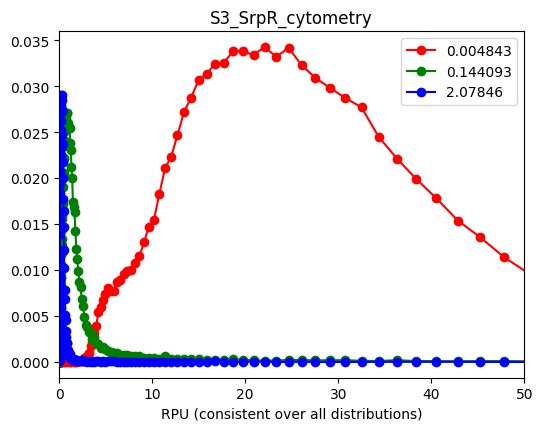

In [80]:
component = functions_lib[40]  # change to see other components: e.g. 30 for 'L1_LitR'

name = component['name']
measurements = component['table']

plt.figure(figsize=figsize)
plt.title(name)
plt.xlabel('RPU (consistent over all distributions)')

# Show some distributions
d = measurements[0]
plt.plot(d['bin'], d['output'], 'ro-', label=d['x'])

middle = int( len(measurements) / 2 )
d = measurements[middle]
plt.plot(d['bin'], d['output'], 'go-', label=d['x'])

d = measurements[-1]
plt.plot(d['bin'], d['output'], 'bo-', label=d['x'])

plt.xlim([0,50])
plt.legend()

# Let's check if the last one was really a distribution
print('Checking if distribution: this should be 1')
print(sum(d['output']))

## The simplified input-output behavior

Using what we learned in Lecture 3, we plot the steady state input-output function of the `NOR` gate.

In [81]:
# Regulation functions
def nor(x, y):
    inputs = x + y  # linear input combination
    params = {}
    for p in model['parameters']:
        params[p['name']] = np.float64(p['value'])
        print(f"{p['name']}: {p['value']}")
    
    # using linear input combination
    Hill_equation = params['ymin'] + (params['ymax'] - params['ymin']) / (1.0 + (inputs / params['K'])**params['n'])                          
    
    # uncomment to use the one from Lecture 3
    # Hill_equation = params['ymin'] + (params['ymax'] - params['ymin']) / \
    #     ( (1.0 + (x / params['K'])**params['n']) * (1.0 + (y / params['K'])**params['n']) )                      

    return Hill_equation

ymax: 3.8
ymin: 0.06
K: 0.07
n: 1.6
alpha: 0.2747976308366057
beta: 1.0


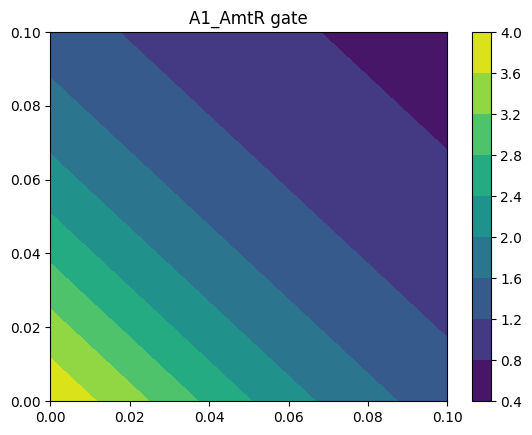

In [82]:
# this is just copied from Lecture 3
def contour_fun(x, y, z, title=None):
    """
    Make a filled contour plot given x, y, z
    in 2D arrays.
    """
    plt.figure()
    CS = plt.contourf(x, y, z)
    cbar = plt.colorbar(CS)
    if title is not None:
        plt.title(title)

# Get x and y values for plotting
x = np.linspace(0, 0.1, 200)
y = np.linspace(0, 0.1, 200)
xx, yy = np.meshgrid(x, y)

# plot it
contour_fun(xx, yy,
            nor(xx, yy),
            title=f"{gate_name} gate")

## Model based on experimental data

To simplify this undertaking, we only model the expected input-output behavior.

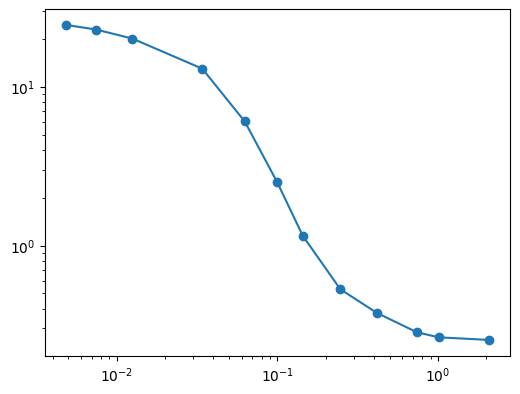

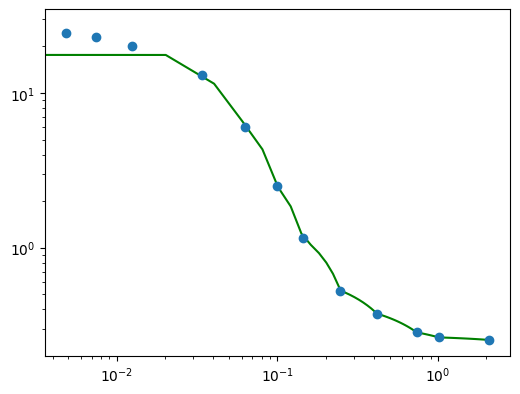

In [83]:
# compute the mean
x = []
y = []
for d in measurements:
    x += [ d['x'] ]
    y += [ np.average(d['bin'], weights=d['output']) ]
    
plt.figure(figsize=figsize)
plt.loglog(x,y,'o-')

# let's create a function from it that we can use
# we go for linear interpolation
# and enable extrapolation to be able to use it for values
# outside of the given data range
Hill_measured = interp1d(x,y, fill_value='extrapolate')

# and show it
plt.figure(figsize=figsize)
x_new = np.linspace(0,2,100)
plt.loglog(x_new, Hill_measured(x_new), 'g-')
plt.loglog(x, y, 'o')

We are now ready to use it as a `NOR` model.
Mind that we do not have experimental data on the individual inputs, so we go for the linear combination as proposed in the Cello v2 model of the `NOR`.

ymax: 3.8
ymin: 0.06
K: 0.07
n: 1.6
alpha: 0.2747976308366057
beta: 1.0


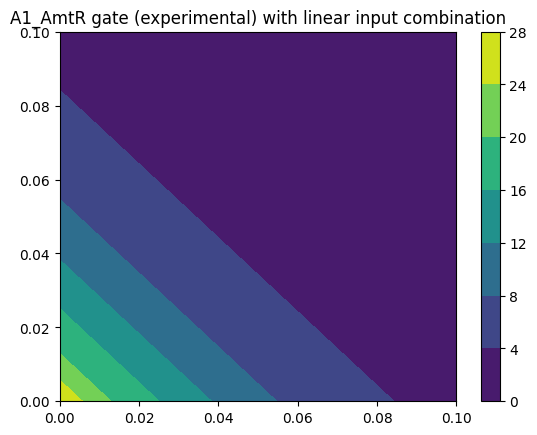

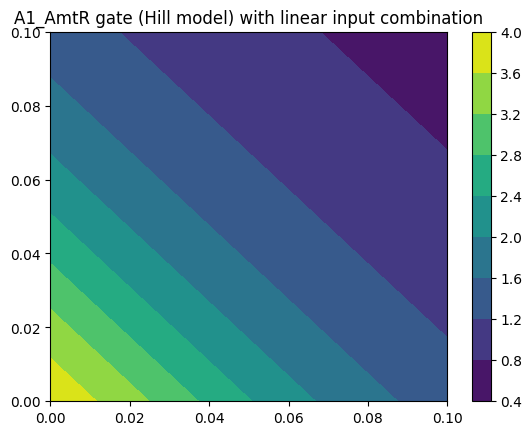

In [84]:
def nor_experimental(x, y):
    inputs = x + y  # linear input combination
    
    # using linear input combination
    Hill_equation = Hill_measured(inputs)                                              

    return Hill_equation

# Get x and y values for plotting
x = np.linspace(0, 0.1, 200)
y = np.linspace(0, 0.1, 200)
xx, yy = np.meshgrid(x, y)

# plot it
contour_fun(xx, yy,
            nor_experimental(xx, yy),
            title=f"{gate_name} gate (experimental) with linear input combination")
contour_fun(xx, yy,
            nor(xx, yy),
            title=f"{gate_name} gate (Hill model) with linear input combination")

# Problem 2: Gate characteristics

Plot all deterministic Hill models for all `NOR` gates in log-log plots.
You can plot them for a single input (the linearly added two inputs).

The plot should be nicely arranged so that the viewer can compare them next to each other.
For example in a 5 x 4 grid (e.g., using `subplots` in `matplotlib`).
Also think about common axis limits, etc.

What do you observe for the gate library.

# Problem 3: Simulation of Inverter Chain

Propagate determinsitic input-output values from inputs to an output.
Write a function that allows you to call `progagate(circuit: list[str], i: float) -> float`.
Here, `circuit` is a linear circuit of `NOR` gates but with a single input (`INV` gates).
The circuit is encoded as a `list[str]` of `NOR` names from the library.
Argument `i` is an input value in RPUs.

The output of the function is the output of the circuit in RPUs.
